In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.linalg

sns.set_style("whitegrid")

#### Coefficients

In [2]:
alpha = 1 / 3
beta = .99
delta = .025
psi = 2.
rho = .98
h = 1 / 3

# in following variable names: 'ss ~ steady state'

### Compute Objects

In [3]:
ss_capital = h * ((1/beta - 1 + delta) / alpha) ** (1 / (alpha - 1))
ss_prod = (ss_capital ** alpha) * (h ** (1 - alpha))
ss_consum = ss_prod - delta * ss_capital
ss_invest = delta * ss_capital

In [4]:
m = 1 - beta * (1 - delta)
b = alpha + (1-delta) * (ss_capital / ss_prod)

A = np.array([
    [m*(1-alpha)         , -m     , 1, -m*(1-alpha)],
    [0                   , 0      , 0, 0           ],
    [ss_capital / ss_prod, 0      , 0, 0           ],
    [0                   , 1 / rho, 0, 0           ],
])

B = np.array([
    [0    , 0, 1                   , 0             ],
    [alpha, 1, -1                  , -(psi + alpha)],
    [b    , 1, -ss_consum / ss_prod, 1 - alpha     ],
    [0    , 1, 0                   , 0             ],
])

### g)

In the function ``scipy.linalg.ordqz`` I set ``sort="ouc"`` which stands for _outside unit circle_. This achieves the desired order for our problem.

In [5]:
S, T, _, _, Q, Z =  scipy.linalg.ordqz(A, B, sort="ouc")

### h)

In [6]:
eigen_values = np.diag(T) / np.diag(S)

I = np.where(np.abs(eigen_values) < 1)[0]

ns = len(I)

S_11, T_11, Z_11 = (m[:ns, :ns] for m in (S, T, Z))
Z_21 = Z[ns:, :ns]

Z_11_inverse = np.linalg.inv(Z_11)

#### (Linear) Mappings from States to States and States to Controls:

In [7]:
S2S = Z_11 @ np.linalg.inv(S_11) @ T_11 @ np.linalg.inv(Z_11) # states to states
S2C = Z_21 @ np.linalg.inv(Z_11)                              # states to controls

### j)

In [8]:
def simulate_impulse_response(S2S, S2C, shock_level, n_periods):
    """Simulate impulse response path.
    
    Args:
        S2S (np.ndarray): Array mapping states to states
        S2C (np.ndarray): Array mapping states to controls
        shock_level (float): Size of technology shock
        n_periods (int): Number of periods to simulate.
        
    Returns:
        df (pd.DataFrame): Data frame with simulated variables.
            Columns are 'periods', 'variable' and 'value', where
            'variable' is in "capital", "productivity",
            "consumption", "labor", "investment", "prodution"
    
    """
    ns = len(S2S)
    nc = len(S2C)
    
    # result will contain state and controls for all time periods plus further info
    # columns of result will be [capital, productivity, consum, labor, investment,
    # production]
    result = np.empty((n_periods, ns + nc + 2))
    
    state = np.array([0, shock_level])
    
    for t in range(n_periods):
        
        controls = S2C @ state
        updated_state = S2S @ state
        
        result[t, :ns] = state
        result[t, ns:(ns + nc)] = controls
        
        investment = (updated_state[0] - (1 - delta) * state[0]) / delta
        prod = ss_consum / ss_prod * controls[0] + ss_invest / ss_prod * investment
        
        result[t, -2] = investment
        result[t, -1] = prod
        
        state = updated_state
        
    result /= shock_level
    
    df = pd.DataFrame(result, columns=[
        "capital", "productivity", "consumption", "labor", "investment", "prodution"
    ])
    df.index.name = "periods"
    df = df.reset_index().melt(id_vars="periods", var_name="variable")
    return df

#### Actual Computation:

In [9]:
impulse_response = simulate_impulse_response(
    S2S, S2C, shock_level=.007, n_periods=400
)

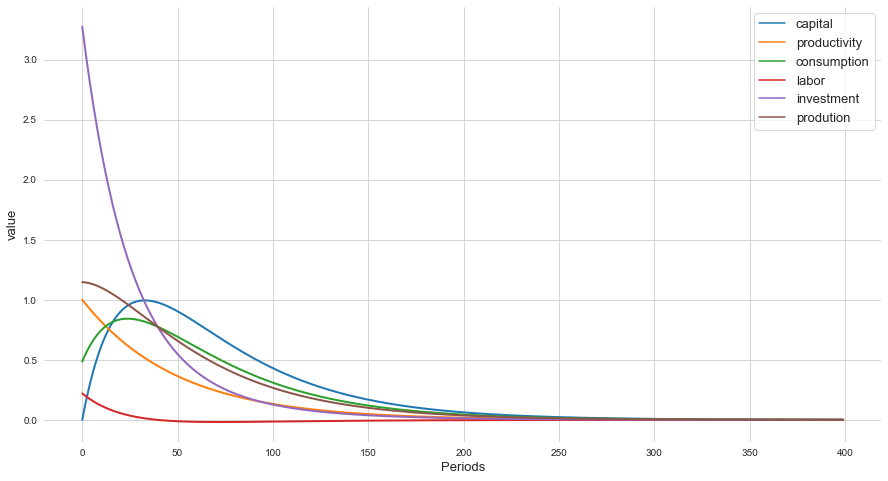

In [10]:
fig, ax = plt.subplots(1)
fig.set_size_inches(15, 8)

sns.lineplot(
    x="periods",
    y="value",
    data=impulse_response,
    hue="variable",
    legend="brief",
    linewidth=2,
    ax=ax,
)

ax.set(xlabel="Periods")
ax.set_frame_on(False)
ax.xaxis.label.set_size(13)
ax.yaxis.label.set_size(13)
plt.legend(prop={'size': 13})
plt.show()